In [317]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [318]:
import sys
sys.path.append("../")
import numpy as np
from itertools import product
from matplotlib import pyplot as plt
import seaborn as sns
from simulation import *

### Bivariate Normal Data Generation

In [390]:
from simulation import get_sampler, cls_to_dset, get_train_test_samples
MU = {
    0: [4, 3],
    1: [4, 1],
    2: [3, 5],
    3: [2, 2]
}
std = 0.2
COV = {
    0: np.eye(2)*std**2,
    1: np.eye(2)*std**2,
    2: np.eye(2)*std**2,
    3: np.eye(2)*std**2
}
K = 4
SAMPLERS = get_sampler(MU, COV, K)
# Get SAMPLES
n = 1000
X_TRAIN, Y_TRAIN, X_TEST, Y_TEST = get_train_test_samples(SAMPLERS=SAMPLERS, n=n)
# Dataset
IND_CLS = [0, 1, 2]
OOD_CLS = [3]
IND_DATA, IND_X, IND_Y = cls_to_dset(IND_CLS, X_TRAIN, Y_TRAIN)
OOD_DATA, OOD_X, OOD_Y = cls_to_dset(OOD_CLS, X_TRAIN, Y_TRAIN)
IND_DATA_TEST, IND_X_TEST, IND_Y_TEST = cls_to_dset(IND_CLS, X_TEST, Y_TEST)
OOD_DATA_TEST, OOD_X_TEST, OOD_Y_TEST = cls_to_dset(OOD_CLS, X_TEST, Y_TEST)

#### Plot

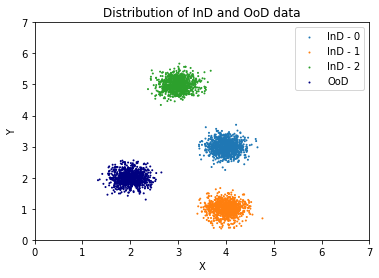

In [391]:
for idx in IND_CLS:
    plt.scatter(IND_X[:,0][IND_Y==idx], IND_X[:,1][IND_Y==idx], label =f"InD - {idx}", sizes=[1]*len(IND_X),alpha=1)
plt.scatter(OOD_X[:,0], OOD_X[:,1], c='navy', label ="OoD", sizes=[1]*len(OOD_X), alpha=1)
plt.xlim((0, 7))
plt.ylim((0, 7))
plt.legend()
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Distribution of InD and OoD data")
plt.show()

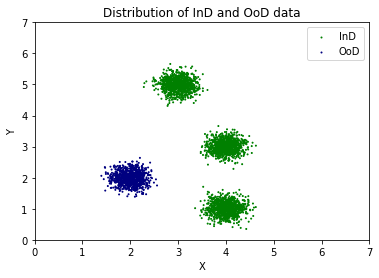

In [387]:
plt.scatter(IND_X[:,0], IND_X[:,1], c='green', label ="InD", sizes=[1]*len(IND_X),alpha=1)
plt.scatter(OOD_X[:,0], OOD_X[:,1], c='navy', label ="OoD", sizes=[1]*len(OOD_X), alpha=1)
plt.xlim((0, 7))
plt.ylim((0, 7))
plt.legend()
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Distribution of InD and OoD data")
plt.show()

### Naive Classifier Training

In [392]:
from tqdm import tqdm
from simulation import classifier_training
D = DSIM()
# Configuration
max_epoch = 256
lr = 1e-3
optimizer = torch.optim.Adam(D.parameters(), lr=lr, betas=(0.9, 0.999))
criterion = nn.CrossEntropyLoss()
# Dataset
ind_tri_loader = torch.utils.data.DataLoader(IND_DATA, shuffle=True, batch_size=256)
ind_val_loader = torch.utils.data.DataLoader(IND_DATA_TEST, shuffle=True, batch_size=256)
# Training
D = classifier_training(D, criterion, optimizer, ind_tri_loader, ind_val_loader, max_epoch, n_epoch=50)
torch.save(D.state_dict(), "simulation_log/model/D.pt")

  2%|▏         | 4/256 [00:00<00:14, 17.18it/s]

Epoch  # 1 | Tri loss: 1.1592                     | Tri accuracy: 0.3316
Epoch  # 1 | Val loss: 1.14                     | Val accuracy: 0.3327


 21%|██        | 53/256 [00:02<00:08, 23.62it/s]

Epoch  # 51 | Tri loss: 0.039                     | Tri accuracy: 1.0
Epoch  # 51 | Val loss: 0.0363                     | Val accuracy: 1.0


 41%|████      | 104/256 [00:04<00:06, 24.93it/s]

Epoch  # 101 | Tri loss: 0.0066                     | Tri accuracy: 1.0
Epoch  # 101 | Val loss: 0.0058                     | Val accuracy: 1.0


 61%|██████    | 155/256 [00:06<00:04, 24.63it/s]

Epoch  # 151 | Tri loss: 0.0025                     | Tri accuracy: 1.0
Epoch  # 151 | Val loss: 0.0021                     | Val accuracy: 1.0


 80%|████████  | 205/256 [00:08<00:02, 24.55it/s]

Epoch  # 201 | Tri loss: 0.0013                     | Tri accuracy: 1.0
Epoch  # 201 | Val loss: 0.001                     | Val accuracy: 1.0


 99%|█████████▉| 253/256 [00:10<00:00, 25.14it/s]

Epoch  # 251 | Tri loss: 0.0005                     | Tri accuracy: 1.0
Epoch  # 251 | Val loss: 0.0003                     | Val accuracy: 1.0


100%|██████████| 256/256 [00:10<00:00, 23.42it/s]


#### Plot

torch.Size([10000, 3])


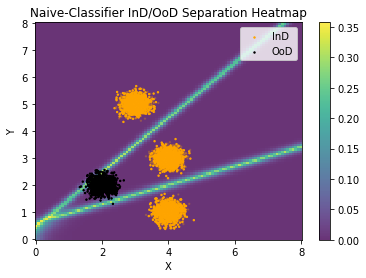

In [393]:
plot_wood = plot_heatmap(IND_X=IND_X, IND_X_TEST=IND_X_TEST, OOD_X=OOD_X, OOD_BATCH=OOD_X, 
                    D=D, method="Naive-Classifier", m=100)

### WOOD Training

In [394]:
from simulation import *
D_WOOD = DSIM(16)
# OOD data preparation
n_ood = 2
ood_bsz = 8
OOD_BATCH = torch.tensor(OOD_X[np.random.choice(n, n_ood, replace=False)], dtype=torch.float32)
torch.save(OOD_BATCH, "simulation_log/model/ood_batch.pt")
print(f"OOD Batch Shape: {OOD_BATCH.shape}")
# Configuration
max_epoch = 128
lr = 1e-3
beta = 0.1
optimizer = torch.optim.Adam(D_WOOD.parameters(), lr=lr, betas=(0.9, 0.999))
criterion = nn.CrossEntropyLoss()
# Dataset
ind_tri_loader = torch.utils.data.DataLoader(IND_DATA, shuffle=True, batch_size=256)
ind_val_loader = torch.utils.data.DataLoader(IND_DATA_TEST, shuffle=True, batch_size=256)
# Training
D_WOOD = wood_training(D_WOOD, OOD_BATCH, ood_bsz, beta, criterion, optimizer, ind_tri_loader, ind_val_loader, max_epoch, n_epoch=10)

OOD Batch Shape: torch.Size([2, 2])


  1%|          | 1/128 [00:00<00:44,  2.85it/s]

Epoch  # 1 | Tri loss: 1.1704                     | Tri accuracy: 0.0961
Epoch  # 1 | Val loss: 1.1656                     | Val accuracy: 0.3334


  9%|▊         | 11/128 [00:03<00:32,  3.62it/s]

Epoch  # 11 | Tri loss: 0.7851                     | Tri accuracy: 0.8964
Epoch  # 11 | Val loss: 0.7986                     | Val accuracy: 0.923


 16%|█▋        | 21/128 [00:06<00:36,  2.95it/s]

Epoch  # 21 | Tri loss: 0.404                     | Tri accuracy: 0.9882
Epoch  # 21 | Val loss: 0.4238                     | Val accuracy: 0.9927


 24%|██▍       | 31/128 [00:09<00:28,  3.42it/s]

Epoch  # 31 | Tri loss: 0.2146                     | Tri accuracy: 0.9993
Epoch  # 31 | Val loss: 0.2403                     | Val accuracy: 1.0


 32%|███▏      | 41/128 [00:12<00:25,  3.36it/s]

Epoch  # 41 | Tri loss: 0.11                     | Tri accuracy: 1.0
Epoch  # 41 | Val loss: 0.1392                     | Val accuracy: 1.0


 40%|███▉      | 51/128 [00:15<00:22,  3.43it/s]

Epoch  # 51 | Tri loss: 0.0588                     | Tri accuracy: 1.0
Epoch  # 51 | Val loss: 0.091                     | Val accuracy: 1.0


 48%|████▊     | 61/128 [00:18<00:19,  3.42it/s]

Epoch  # 61 | Tri loss: 0.0295                     | Tri accuracy: 1.0
Epoch  # 61 | Val loss: 0.0615                     | Val accuracy: 1.0


 55%|█████▌    | 71/128 [00:21<00:16,  3.51it/s]

Epoch  # 71 | Tri loss: 0.0147                     | Tri accuracy: 1.0
Epoch  # 71 | Val loss: 0.0486                     | Val accuracy: 1.0


 63%|██████▎   | 81/128 [00:23<00:13,  3.60it/s]

Epoch  # 81 | Tri loss: 0.0057                     | Tri accuracy: 1.0
Epoch  # 81 | Val loss: 0.0392                     | Val accuracy: 1.0


 71%|███████   | 91/128 [00:26<00:10,  3.67it/s]

Epoch  # 91 | Tri loss: -0.0003                     | Tri accuracy: 1.0
Epoch  # 91 | Val loss: 0.0326                     | Val accuracy: 1.0


 79%|███████▉  | 101/128 [00:29<00:07,  3.70it/s]

Epoch  # 101 | Tri loss: -0.0054                     | Tri accuracy: 1.0
Epoch  # 101 | Val loss: 0.0286                     | Val accuracy: 1.0


 87%|████████▋ | 111/128 [00:32<00:04,  3.68it/s]

Epoch  # 111 | Tri loss: -0.0089                     | Tri accuracy: 1.0
Epoch  # 111 | Val loss: 0.0247                     | Val accuracy: 1.0


 95%|█████████▍| 121/128 [00:34<00:01,  3.75it/s]

Epoch  # 121 | Tri loss: -0.0117                     | Tri accuracy: 1.0
Epoch  # 121 | Val loss: 0.0226                     | Val accuracy: 1.0


100%|██████████| 128/128 [00:36<00:00,  3.47it/s]


torch.Size([10000, 3])


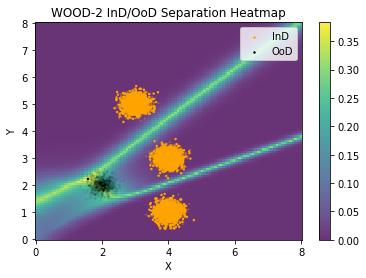

In [395]:
plot_wood = plot_heatmap(IND_X=IND_X, IND_X_TEST=IND_X_TEST, OOD_X=OOD_X, OOD_BATCH=OOD_BATCH, 
                    D=D_WOOD, method=f"WOOD-{n_ood}", m=100)

In [396]:
from simulation import calculate_accuracy
calculate_accuracy(D=D, ind=IND_X, ood=OOD_X, tnr=0.95)
calculate_accuracy(D=D_WOOD, ind=IND_X, ood=OOD_X, tnr=0.95)

torch.Size([3000, 3])
torch.Size([3000])
5.093148502055547e-06
torch.Size([1000, 3])
tensor(1.)
torch.Size([3000, 3])
torch.Size([3000])
0.006974377296864977
torch.Size([1000, 3])
tensor(1.)


In [402]:
calculate_accuracy(D=D, ind=IND_X, ood=OOD_X, tnr=0.999)
calculate_accuracy(D=D_WOOD, ind=IND_X, ood=OOD_X, tnr=0.999)

torch.Size([3000, 3])
torch.Size([3000])
0.00538723305892238
torch.Size([1000, 3])
tensor(0.3160)
torch.Size([3000, 3])
torch.Size([3000])
0.027474731121213066
torch.Size([1000, 3])
tensor(1.)


### OOD GAN Training

In [397]:
from simulation import *
D_GAN = DSIM(16)
G_GAN = GSIM(16)
# OOD data preparation
# n_ood = 64
ood_bsz = 8
bsz_tri = 64
# OOD_BATCH = torch.tensor(OOD_X[np.random.choice(n, n_ood, replace=False)], dtype=torch.float32)
print(f"OOD Batch Shape: {OOD_BATCH.shape}")
# Configuration
max_epoch = 128
lr = 1e-3
w_ce, w_wass, w_dist = 1, 0.1, 0.0
n_dim = 1
D_solver = torch.optim.Adam(D_GAN.parameters(), lr=lr, betas=(0.9, 0.999))
G_solver = torch.optim.Adam(G_GAN.parameters(), lr=lr, betas=(0.9, 0.999))
criterion = nn.CrossEntropyLoss()
# Dataset
ind_tri_loader = torch.utils.data.DataLoader(IND_DATA, shuffle=True, batch_size=256)
ind_val_loader = torch.utils.data.DataLoader(IND_DATA_TEST, shuffle=True, batch_size=256)
# Training
oodgan_training(D_GAN, G_GAN, D_solver, G_solver, OOD_BATCH, ood_bsz, bsz_tri, w_ce, w_wass, w_dist,\
                    ind_tri_loader, ind_val_loader, max_epoch, n_epoch=5, n_step_log=10)

OOD Batch Shape: torch.Size([2, 2])


  0%|          | 0/128 [00:00<?, ?it/s]

Step: 0    | D:  1.2171 | CE:  1.2124 | W_OoD:  1.1620 | W_z:  1.0218 | G:  0.0362 | W_z:  1.0147 | dist: 1.8904
Step: 10   | D:  1.0968 | CE:  1.0934 | W_OoD:  1.0679 | W_z:  0.9745 | G:  0.0378 | W_z:  0.9729 | dist: 1.8791


  1%|          | 1/128 [00:15<31:57, 15.10s/it]

Epoch  # 1 | Val accuracy: 0.3339
Step: 8    | D:  1.0303 | CE:  1.0283 | W_OoD:  1.0052 | W_z:  0.9516 | G:  0.0387 | W_z:  0.9484 | dist: 1.8436


  2%|▏         | 2/128 [00:30<31:53, 15.19s/it]

Step: 6    | D:  0.9669 | CE:  0.9661 | W_OoD:  0.9581 | W_z:  0.9387 | G:  0.0391 | W_z:  0.9384 | dist: 1.8127


  2%|▏         | 3/128 [00:45<31:25, 15.08s/it]

Step: 4    | D:  0.9160 | CE:  0.9145 | W_OoD:  0.9760 | W_z:  0.9366 | G:  0.0392 | W_z:  0.9369 | dist: 1.8197


  3%|▎         | 4/128 [01:00<30:51, 14.93s/it]

Step: 2    | D:  0.8793 | CE:  0.8773 | W_OoD:  0.9872 | W_z:  0.9348 | G:  0.0393 | W_z:  0.9351 | dist: 1.8218


  4%|▍         | 5/128 [01:14<30:32, 14.90s/it]

Step: 0    | D:  0.8347 | CE:  0.8326 | W_OoD:  0.9883 | W_z:  0.9345 | G:  0.0393 | W_z:  0.9345 | dist: 1.8216
Step: 10   | D:  0.8244 | CE:  0.8225 | W_OoD:  0.9839 | W_z:  0.9343 | G:  0.0393 | W_z:  0.9342 | dist: 1.8246


  5%|▍         | 6/128 [01:29<29:55, 14.72s/it]

Epoch  # 6 | Val accuracy: 0.9891
Step: 8    | D:  0.7992 | CE:  0.7973 | W_OoD:  0.9833 | W_z:  0.9342 | G:  0.0393 | W_z:  0.9342 | dist: 1.8250


  5%|▌         | 7/128 [01:42<29:00, 14.38s/it]

Step: 6    | D:  0.7596 | CE:  0.7575 | W_OoD:  0.9900 | W_z:  0.9342 | G:  0.0393 | W_z:  0.9342 | dist: 1.8253


  6%|▋         | 8/128 [01:57<28:39, 14.33s/it]

Step: 4    | D:  0.7317 | CE:  0.7292 | W_OoD:  0.9992 | W_z:  0.9341 | G:  0.0393 | W_z:  0.9343 | dist: 1.8244


  7%|▋         | 9/128 [02:11<28:28, 14.36s/it]

Step: 2    | D:  0.6825 | CE:  0.6798 | W_OoD:  1.0064 | W_z:  0.9341 | G:  0.0393 | W_z:  0.9342 | dist: 1.8240


  8%|▊         | 10/128 [02:24<27:38, 14.06s/it]

Step: 0    | D:  0.6630 | CE:  0.6600 | W_OoD:  1.0151 | W_z:  0.9341 | G:  0.0393 | W_z:  0.9340 | dist: 1.8298
Step: 10   | D:  0.6289 | CE:  0.6255 | W_OoD:  1.0266 | W_z:  0.9341 | G:  0.0393 | W_z:  0.9342 | dist: 1.8352


  9%|▊         | 11/128 [02:38<27:14, 13.97s/it]

Epoch  # 11 | Val accuracy: 0.9732
Step: 8    | D:  0.6016 | CE:  0.5978 | W_OoD:  1.0361 | W_z:  0.9341 | G:  0.0393 | W_z:  0.9342 | dist: 1.8330


  9%|▉         | 12/128 [02:52<26:59, 13.96s/it]

Step: 6    | D:  0.5646 | CE:  0.5604 | W_OoD:  1.0460 | W_z:  0.9341 | G:  0.0393 | W_z:  0.9342 | dist: 1.8282


 10%|█         | 13/128 [03:05<26:14, 13.69s/it]

Step: 4    | D:  0.5710 | CE:  0.5665 | W_OoD:  1.0555 | W_z:  0.9341 | G:  0.0393 | W_z:  0.9343 | dist: 1.8335


 11%|█         | 14/128 [03:19<26:02, 13.71s/it]

Step: 2    | D:  0.5403 | CE:  0.5355 | W_OoD:  1.0659 | W_z:  0.9342 | G:  0.0393 | W_z:  0.9342 | dist: 1.8395


 12%|█▏        | 15/128 [03:34<26:28, 14.06s/it]

Step: 0    | D:  0.4899 | CE:  0.4848 | W_OoD:  1.0747 | W_z:  0.9340 | G:  0.0393 | W_z:  0.9341 | dist: 1.8421
Step: 10   | D:  0.4914 | CE:  0.4860 | W_OoD:  1.0831 | W_z:  0.9347 | G:  0.0393 | W_z:  0.9345 | dist: 1.8440


 12%|█▎        | 16/128 [03:49<26:35, 14.24s/it]

Epoch  # 16 | Val accuracy: 0.994
Step: 8    | D:  0.4589 | CE:  0.4532 | W_OoD:  1.0916 | W_z:  0.9348 | G:  0.0393 | W_z:  0.9343 | dist: 1.8437


 13%|█▎        | 17/128 [04:02<26:10, 14.15s/it]

Step: 6    | D:  0.4132 | CE:  0.4072 | W_OoD:  1.1015 | W_z:  0.9341 | G:  0.0393 | W_z:  0.9344 | dist: 1.8402


 14%|█▍        | 18/128 [04:17<25:55, 14.14s/it]

Step: 4    | D:  0.4035 | CE:  0.3974 | W_OoD:  1.1050 | W_z:  0.9340 | G:  0.0393 | W_z:  0.9340 | dist: 1.8362


 15%|█▍        | 19/128 [04:31<25:38, 14.11s/it]

Step: 2    | D:  0.3985 | CE:  0.3922 | W_OoD:  1.1082 | W_z:  0.9341 | G:  0.0393 | W_z:  0.9347 | dist: 1.8358


 16%|█▌        | 20/128 [04:44<24:57, 13.87s/it]

Step: 0    | D:  0.3998 | CE:  0.3934 | W_OoD:  1.1105 | W_z:  0.9345 | G:  0.0393 | W_z:  0.9341 | dist: 1.8339
Step: 10   | D:  0.3600 | CE:  0.3535 | W_OoD:  1.1154 | W_z:  0.9343 | G:  0.0393 | W_z:  0.9340 | dist: 1.8272


 16%|█▋        | 21/128 [04:57<24:14, 13.60s/it]

Epoch  # 21 | Val accuracy: 1.0
Step: 8    | D:  0.3618 | CE:  0.3552 | W_OoD:  1.1173 | W_z:  0.9341 | G:  0.0393 | W_z:  0.9343 | dist: 1.8253


 17%|█▋        | 22/128 [05:10<23:48, 13.48s/it]

Step: 6    | D:  0.3576 | CE:  0.3511 | W_OoD:  1.1122 | W_z:  0.9341 | G:  0.0393 | W_z:  0.9343 | dist: 1.8171


 18%|█▊        | 23/128 [05:24<23:34, 13.47s/it]

Step: 4    | D:  0.3432 | CE:  0.3370 | W_OoD:  1.1062 | W_z:  0.9343 | G:  0.0393 | W_z:  0.9346 | dist: 1.8046


 19%|█▉        | 24/128 [05:38<24:05, 13.90s/it]

Step: 2    | D:  0.3355 | CE:  0.3296 | W_OoD:  1.0977 | W_z:  0.9346 | G:  0.0393 | W_z:  0.9344 | dist: 1.7967


 20%|█▉        | 25/128 [05:54<24:36, 14.34s/it]

Step: 0    | D:  0.3018 | CE:  0.2958 | W_OoD:  1.1008 | W_z:  0.9342 | G:  0.0393 | W_z:  0.9344 | dist: 1.7926
Step: 10   | D:  0.3180 | CE:  0.3120 | W_OoD:  1.0988 | W_z:  0.9343 | G:  0.0393 | W_z:  0.9341 | dist: 1.7847


 20%|██        | 26/128 [06:11<25:59, 15.29s/it]

Epoch  # 26 | Val accuracy: 1.0
Step: 8    | D:  0.3044 | CE:  0.2985 | W_OoD:  1.0982 | W_z:  0.9346 | G:  0.0393 | W_z:  0.9348 | dist: 1.7709


 21%|██        | 27/128 [06:25<24:49, 14.74s/it]

Step: 6    | D:  0.2802 | CE:  0.2745 | W_OoD:  1.0926 | W_z:  0.9347 | G:  0.0393 | W_z:  0.9350 | dist: 1.7525


 22%|██▏       | 28/128 [06:39<24:32, 14.73s/it]

Step: 4    | D:  0.2643 | CE:  0.2585 | W_OoD:  1.0946 | W_z:  0.9349 | G:  0.0393 | W_z:  0.9347 | dist: 1.7472


 23%|██▎       | 29/128 [06:54<24:08, 14.63s/it]

Step: 2    | D:  0.2700 | CE:  0.2644 | W_OoD:  1.0900 | W_z:  0.9342 | G:  0.0393 | W_z:  0.9343 | dist: 1.7416


 23%|██▎       | 30/128 [07:08<23:44, 14.54s/it]

Step: 0    | D:  0.2572 | CE:  0.2517 | W_OoD:  1.0869 | W_z:  0.9347 | G:  0.0393 | W_z:  0.9344 | dist: 1.7344
Step: 10   | D:  0.2599 | CE:  0.2545 | W_OoD:  1.0825 | W_z:  0.9346 | G:  0.0393 | W_z:  0.9345 | dist: 1.7243


 24%|██▍       | 31/128 [07:22<23:06, 14.30s/it]

Epoch  # 31 | Val accuracy: 1.0
Step: 8    | D:  0.2302 | CE:  0.2248 | W_OoD:  1.0820 | W_z:  0.9347 | G:  0.0393 | W_z:  0.9346 | dist: 1.7164


 25%|██▌       | 32/128 [07:35<22:26, 14.03s/it]

Step: 6    | D:  0.2434 | CE:  0.2382 | W_OoD:  1.0778 | W_z:  0.9347 | G:  0.0393 | W_z:  0.9345 | dist: 1.7058


 26%|██▌       | 33/128 [07:49<21:50, 13.79s/it]

Step: 4    | D:  0.2243 | CE:  0.2192 | W_OoD:  1.0745 | W_z:  0.9351 | G:  0.0393 | W_z:  0.9348 | dist: 1.6935


 27%|██▋       | 34/128 [08:02<21:31, 13.74s/it]

Step: 2    | D:  0.2316 | CE:  0.2265 | W_OoD:  1.0728 | W_z:  0.9352 | G:  0.0393 | W_z:  0.9347 | dist: 1.6864


 27%|██▋       | 35/128 [08:16<21:18, 13.74s/it]

Step: 0    | D:  0.2089 | CE:  0.2040 | W_OoD:  1.0689 | W_z:  0.9348 | G:  0.0393 | W_z:  0.9349 | dist: 1.6902
Step: 10   | D:  0.2009 | CE:  0.1959 | W_OoD:  1.0688 | W_z:  0.9343 | G:  0.0393 | W_z:  0.9344 | dist: 1.6959


 28%|██▊       | 36/128 [08:29<20:58, 13.68s/it]

Epoch  # 36 | Val accuracy: 1.0
Step: 8    | D:  0.1900 | CE:  0.1849 | W_OoD:  1.0725 | W_z:  0.9346 | G:  0.0393 | W_z:  0.9346 | dist: 1.7087


 29%|██▉       | 37/128 [08:44<21:05, 13.91s/it]

Step: 6    | D:  0.1818 | CE:  0.1766 | W_OoD:  1.0763 | W_z:  0.9346 | G:  0.0393 | W_z:  0.9346 | dist: 1.7269


 30%|██▉       | 38/128 [08:58<20:59, 14.00s/it]

Step: 4    | D:  0.1793 | CE:  0.1742 | W_OoD:  1.0745 | W_z:  0.9348 | G:  0.0393 | W_z:  0.9348 | dist: 1.7359


 30%|███       | 39/128 [09:12<20:50, 14.05s/it]

Step: 2    | D:  0.1930 | CE:  0.1880 | W_OoD:  1.0690 | W_z:  0.9346 | G:  0.0393 | W_z:  0.9344 | dist: 1.7422


 31%|███▏      | 40/128 [09:26<20:36, 14.05s/it]

Step: 0    | D:  0.1757 | CE:  0.1709 | W_OoD:  1.0654 | W_z:  0.9343 | G:  0.0393 | W_z:  0.9345 | dist: 1.7375
Step: 10   | D:  0.1790 | CE:  0.1745 | W_OoD:  1.0574 | W_z:  0.9349 | G:  0.0393 | W_z:  0.9352 | dist: 1.7316


 32%|███▏      | 41/128 [09:40<20:24, 14.08s/it]

Epoch  # 41 | Val accuracy: 1.0
Step: 8    | D:  0.1752 | CE:  0.1709 | W_OoD:  1.0512 | W_z:  0.9348 | G:  0.0392 | W_z:  0.9354 | dist: 1.7305


 33%|███▎      | 42/128 [09:55<20:10, 14.08s/it]

Step: 6    | D:  0.1767 | CE:  0.1725 | W_OoD:  1.0467 | W_z:  0.9347 | G:  0.0393 | W_z:  0.9348 | dist: 1.7277


 34%|███▎      | 43/128 [10:09<20:04, 14.17s/it]

Step: 4    | D:  0.1609 | CE:  0.1569 | W_OoD:  1.0426 | W_z:  0.9349 | G:  0.0393 | W_z:  0.9348 | dist: 1.7255


 34%|███▍      | 44/128 [10:24<20:03, 14.33s/it]

Step: 2    | D:  0.1674 | CE:  0.1636 | W_OoD:  1.0366 | W_z:  0.9345 | G:  0.0393 | W_z:  0.9346 | dist: 1.7284


 35%|███▌      | 45/128 [10:38<20:01, 14.48s/it]

Step: 0    | D:  0.1521 | CE:  0.1484 | W_OoD:  1.0338 | W_z:  0.9343 | G:  0.0393 | W_z:  0.9345 | dist: 1.7307
Step: 10   | D:  0.1495 | CE:  0.1461 | W_OoD:  1.0262 | W_z:  0.9342 | G:  0.0393 | W_z:  0.9343 | dist: 1.7373


 36%|███▌      | 46/128 [10:52<19:11, 14.05s/it]

Epoch  # 46 | Val accuracy: 1.0
Step: 8    | D:  0.1491 | CE:  0.1460 | W_OoD:  1.0179 | W_z:  0.9349 | G:  0.0393 | W_z:  0.9343 | dist: 1.7367


 37%|███▋      | 47/128 [11:04<18:32, 13.73s/it]

Step: 6    | D:  0.1452 | CE:  0.1423 | W_OoD:  1.0098 | W_z:  0.9344 | G:  0.0393 | W_z:  0.9347 | dist: 1.7372


 38%|███▊      | 48/128 [11:18<18:01, 13.52s/it]

Step: 4    | D:  0.1594 | CE:  0.1570 | W_OoD:  0.9991 | W_z:  0.9348 | G:  0.0393 | W_z:  0.9343 | dist: 1.7403


 38%|███▊      | 49/128 [11:30<17:34, 13.35s/it]

Step: 2    | D:  0.1334 | CE:  0.1308 | W_OoD:  1.0031 | W_z:  0.9344 | G:  0.0393 | W_z:  0.9345 | dist: 1.7384


 39%|███▉      | 50/128 [11:43<17:12, 13.23s/it]

Step: 0    | D:  0.1324 | CE:  0.1298 | W_OoD:  1.0021 | W_z:  0.9342 | G:  0.0393 | W_z:  0.9347 | dist: 1.7382
Step: 10   | D:  0.1246 | CE:  0.1218 | W_OoD:  1.0109 | W_z:  0.9362 | G:  0.0392 | W_z:  0.9357 | dist: 1.7422


 40%|███▉      | 51/128 [11:57<16:56, 13.20s/it]

Epoch  # 51 | Val accuracy: 1.0
Step: 8    | D:  0.1158 | CE:  0.1130 | W_OoD:  1.0083 | W_z:  0.9350 | G:  0.0393 | W_z:  0.9343 | dist: 1.7448


 41%|████      | 52/128 [12:12<17:33, 13.86s/it]

Step: 6    | D:  0.1109 | CE:  0.1081 | W_OoD:  1.0065 | W_z:  0.9346 | G:  0.0392 | W_z:  0.9355 | dist: 1.7489


 41%|████▏     | 53/128 [12:27<17:46, 14.21s/it]

Step: 4    | D:  0.1104 | CE:  0.1078 | W_OoD:  1.0044 | W_z:  0.9357 | G:  0.0392 | W_z:  0.9356 | dist: 1.7455


 42%|████▏     | 54/128 [12:41<17:31, 14.21s/it]

Step: 2    | D:  0.1066 | CE:  0.1035 | W_OoD:  1.0160 | W_z:  0.9343 | G:  0.0393 | W_z:  0.9340 | dist: 1.7467


 43%|████▎     | 55/128 [12:56<17:34, 14.44s/it]

Step: 0    | D:  0.0935 | CE:  0.0909 | W_OoD:  1.0050 | W_z:  0.9346 | G:  0.0393 | W_z:  0.9344 | dist: 1.7454
Step: 10   | D:  0.0948 | CE:  0.0918 | W_OoD:  1.0137 | W_z:  0.9344 | G:  0.0393 | W_z:  0.9347 | dist: 1.7435


 44%|████▍     | 56/128 [13:11<17:33, 14.64s/it]

Epoch  # 56 | Val accuracy: 1.0
Step: 8    | D:  0.0930 | CE:  0.0903 | W_OoD:  1.0060 | W_z:  0.9357 | G:  0.0393 | W_z:  0.9348 | dist: 1.7443


 45%|████▍     | 57/128 [13:26<17:24, 14.71s/it]

Step: 6    | D:  0.0877 | CE:  0.0850 | W_OoD:  1.0061 | W_z:  0.9353 | G:  0.0393 | W_z:  0.9351 | dist: 1.7445


 45%|████▌     | 58/128 [13:40<16:42, 14.32s/it]

Step: 4    | D:  0.0916 | CE:  0.0886 | W_OoD:  1.0144 | W_z:  0.9355 | G:  0.0393 | W_z:  0.9345 | dist: 1.7446


 46%|████▌     | 59/128 [13:57<17:22, 15.11s/it]

Step: 2    | D:  0.0857 | CE:  0.0832 | W_OoD:  1.0017 | W_z:  0.9353 | G:  0.0393 | W_z:  0.9345 | dist: 1.7464


 47%|████▋     | 60/128 [14:13<17:32, 15.47s/it]

Step: 0    | D:  0.0843 | CE:  0.0816 | W_OoD:  1.0053 | W_z:  0.9344 | G:  0.0393 | W_z:  0.9341 | dist: 1.7486
Step: 10   | D:  0.0822 | CE:  0.0797 | W_OoD:  1.0012 | W_z:  0.9355 | G:  0.0392 | W_z:  0.9360 | dist: 1.7514


 48%|████▊     | 61/128 [14:28<17:00, 15.23s/it]

Epoch  # 61 | Val accuracy: 1.0
Step: 8    | D:  0.0800 | CE:  0.0774 | W_OoD:  1.0034 | W_z:  0.9344 | G:  0.0393 | W_z:  0.9349 | dist: 1.7474


 48%|████▊     | 62/128 [14:43<16:45, 15.23s/it]

Step: 6    | D:  0.0750 | CE:  0.0721 | W_OoD:  1.0111 | W_z:  0.9347 | G:  0.0393 | W_z:  0.9350 | dist: 1.7455


 49%|████▉     | 63/128 [14:57<16:15, 15.00s/it]

Step: 4    | D:  0.0773 | CE:  0.0747 | W_OoD:  1.0027 | W_z:  0.9350 | G:  0.0392 | W_z:  0.9357 | dist: 1.7478


 50%|█████     | 64/128 [15:11<15:40, 14.69s/it]

Step: 2    | D:  0.0713 | CE:  0.0683 | W_OoD:  1.0121 | W_z:  0.9340 | G:  0.0393 | W_z:  0.9343 | dist: 1.7550


 51%|█████     | 65/128 [15:25<15:17, 14.56s/it]

Step: 0    | D:  0.0752 | CE:  0.0725 | W_OoD:  1.0040 | W_z:  0.9344 | G:  0.0393 | W_z:  0.9340 | dist: 1.7601
Step: 10   | D:  0.0701 | CE:  0.0677 | W_OoD:  0.9983 | W_z:  0.9341 | G:  0.0393 | W_z:  0.9347 | dist: 1.7631


 52%|█████▏    | 66/128 [15:40<14:56, 14.46s/it]

Epoch  # 66 | Val accuracy: 1.0
Step: 8    | D:  0.0652 | CE:  0.0625 | W_OoD:  1.0043 | W_z:  0.9343 | G:  0.0393 | W_z:  0.9349 | dist: 1.7634


 52%|█████▏    | 67/128 [15:54<14:41, 14.45s/it]

Step: 6    | D:  0.0635 | CE:  0.0608 | W_OoD:  1.0070 | W_z:  0.9341 | G:  0.0393 | W_z:  0.9349 | dist: 1.7712


 53%|█████▎    | 68/128 [16:09<14:41, 14.69s/it]

Step: 4    | D:  0.0661 | CE:  0.0635 | W_OoD:  1.0020 | W_z:  0.9341 | G:  0.0393 | W_z:  0.9340 | dist: 1.7845


 54%|█████▍    | 69/128 [16:24<14:31, 14.77s/it]

Step: 2    | D:  0.0685 | CE:  0.0660 | W_OoD:  0.9980 | W_z:  0.9341 | G:  0.0393 | W_z:  0.9343 | dist: 1.8029


 55%|█████▍    | 70/128 [16:39<14:17, 14.79s/it]

Step: 0    | D:  0.0652 | CE:  0.0627 | W_OoD:  1.0001 | W_z:  0.9344 | G:  0.0393 | W_z:  0.9347 | dist: 1.8354
Step: 10   | D:  0.0603 | CE:  0.0578 | W_OoD:  0.9989 | W_z:  0.9345 | G:  0.0393 | W_z:  0.9348 | dist: 1.8543


 55%|█████▌    | 71/128 [16:54<14:12, 14.96s/it]

Epoch  # 71 | Val accuracy: 1.0
Step: 8    | D:  0.0623 | CE:  0.0599 | W_OoD:  0.9962 | W_z:  0.9349 | G:  0.0393 | W_z:  0.9350 | dist: 1.8379


 56%|█████▋    | 72/128 [17:09<13:42, 14.69s/it]

Step: 6    | D:  0.0604 | CE:  0.0581 | W_OoD:  0.9958 | W_z:  0.9350 | G:  0.0393 | W_z:  0.9348 | dist: 1.8210


 57%|█████▋    | 73/128 [17:23<13:20, 14.55s/it]

Step: 4    | D:  0.0556 | CE:  0.0534 | W_OoD:  0.9934 | W_z:  0.9346 | G:  0.0393 | W_z:  0.9345 | dist: 1.8138


 58%|█████▊    | 74/128 [17:37<12:58, 14.42s/it]

Step: 2    | D:  0.0588 | CE:  0.0566 | W_OoD:  0.9931 | W_z:  0.9348 | G:  0.0392 | W_z:  0.9352 | dist: 1.8269


 59%|█████▊    | 75/128 [17:51<12:40, 14.36s/it]

Step: 0    | D:  0.0546 | CE:  0.0522 | W_OoD:  0.9996 | W_z:  0.9351 | G:  0.0393 | W_z:  0.9349 | dist: 1.8604
Step: 10   | D:  0.0580 | CE:  0.0557 | W_OoD:  0.9973 | W_z:  0.9349 | G:  0.0393 | W_z:  0.9348 | dist: 1.8682


 59%|█████▉    | 76/128 [18:05<12:22, 14.28s/it]

Epoch  # 76 | Val accuracy: 1.0
Step: 8    | D:  0.0621 | CE:  0.0599 | W_OoD:  0.9926 | W_z:  0.9350 | G:  0.0393 | W_z:  0.9352 | dist: 1.8429


 60%|██████    | 77/128 [18:19<12:05, 14.23s/it]

Step: 6    | D:  0.0533 | CE:  0.0513 | W_OoD:  0.9877 | W_z:  0.9352 | G:  0.0392 | W_z:  0.9356 | dist: 1.7775


 61%|██████    | 78/128 [18:33<11:50, 14.20s/it]

Step: 4    | D:  0.0594 | CE:  0.0574 | W_OoD:  0.9889 | W_z:  0.9351 | G:  0.0393 | W_z:  0.9349 | dist: 1.7224


 62%|██████▏   | 79/128 [18:48<11:37, 14.24s/it]

Step: 2    | D:  0.0522 | CE:  0.0503 | W_OoD:  0.9833 | W_z:  0.9348 | G:  0.0393 | W_z:  0.9349 | dist: 1.6711


 62%|██████▎   | 80/128 [19:02<11:21, 14.19s/it]

Step: 0    | D:  0.0538 | CE:  0.0519 | W_OoD:  0.9840 | W_z:  0.9349 | G:  0.0392 | W_z:  0.9353 | dist: 1.6428
Step: 10   | D:  0.0543 | CE:  0.0525 | W_OoD:  0.9822 | W_z:  0.9347 | G:  0.0393 | W_z:  0.9348 | dist: 1.6307


 63%|██████▎   | 81/128 [19:16<11:06, 14.18s/it]

Epoch  # 81 | Val accuracy: 1.0
Step: 8    | D:  0.0552 | CE:  0.0534 | W_OoD:  0.9794 | W_z:  0.9345 | G:  0.0393 | W_z:  0.9349 | dist: 1.6338


 64%|██████▍   | 82/128 [19:30<10:53, 14.22s/it]

Step: 6    | D:  0.0512 | CE:  0.0495 | W_OoD:  0.9781 | W_z:  0.9344 | G:  0.0393 | W_z:  0.9347 | dist: 1.6439


 65%|██████▍   | 83/128 [19:45<10:42, 14.27s/it]

Step: 4    | D:  0.0522 | CE:  0.0506 | W_OoD:  0.9772 | W_z:  0.9345 | G:  0.0392 | W_z:  0.9360 | dist: 1.6502


 66%|██████▌   | 84/128 [19:59<10:24, 14.19s/it]

Step: 2    | D:  0.0538 | CE:  0.0522 | W_OoD:  0.9762 | W_z:  0.9341 | G:  0.0393 | W_z:  0.9350 | dist: 1.6546


 66%|██████▋   | 85/128 [20:13<10:08, 14.15s/it]

Step: 0    | D:  0.0545 | CE:  0.0531 | W_OoD:  0.9733 | W_z:  0.9347 | G:  0.0393 | W_z:  0.9347 | dist: 1.6589
Step: 10   | D:  0.0502 | CE:  0.0486 | W_OoD:  0.9748 | W_z:  0.9355 | G:  0.0392 | W_z:  0.9361 | dist: 1.6628


 67%|██████▋   | 86/128 [20:27<09:58, 14.25s/it]

Epoch  # 86 | Val accuracy: 1.0
Step: 8    | D:  0.0481 | CE:  0.0465 | W_OoD:  0.9749 | W_z:  0.9344 | G:  0.0393 | W_z:  0.9347 | dist: 1.6666


 68%|██████▊   | 87/128 [20:42<09:45, 14.29s/it]

Step: 6    | D:  0.0482 | CE:  0.0467 | W_OoD:  0.9716 | W_z:  0.9342 | G:  0.0393 | W_z:  0.9342 | dist: 1.6673


 69%|██████▉   | 88/128 [20:56<09:38, 14.46s/it]

Step: 4    | D:  0.0503 | CE:  0.0490 | W_OoD:  0.9693 | W_z:  0.9361 | G:  0.0393 | W_z:  0.9350 | dist: 1.6674


 70%|██████▉   | 89/128 [21:11<09:26, 14.53s/it]

Step: 2    | D:  0.0469 | CE:  0.0455 | W_OoD:  0.9716 | W_z:  0.9358 | G:  0.0392 | W_z:  0.9360 | dist: 1.6719


 70%|███████   | 90/128 [21:26<09:18, 14.71s/it]

Step: 0    | D:  0.0467 | CE:  0.0452 | W_OoD:  0.9731 | W_z:  0.9353 | G:  0.0393 | W_z:  0.9349 | dist: 1.6746
Step: 10   | D:  0.0523 | CE:  0.0510 | W_OoD:  0.9675 | W_z:  0.9344 | G:  0.0393 | W_z:  0.9340 | dist: 1.6765


 71%|███████   | 91/128 [21:40<08:52, 14.40s/it]

Epoch  # 91 | Val accuracy: 1.0
Step: 8    | D:  0.0491 | CE:  0.0479 | W_OoD:  0.9675 | W_z:  0.9359 | G:  0.0393 | W_z:  0.9349 | dist: 1.6776


 72%|███████▏  | 92/128 [21:55<08:46, 14.62s/it]

Step: 6    | D:  0.0439 | CE:  0.0427 | W_OoD:  0.9666 | W_z:  0.9360 | G:  0.0392 | W_z:  0.9361 | dist: 1.6764


 73%|███████▎  | 93/128 [22:10<08:31, 14.61s/it]

Step: 4    | D:  0.0447 | CE:  0.0437 | W_OoD:  0.9609 | W_z:  0.9351 | G:  0.0393 | W_z:  0.9349 | dist: 1.6763


 73%|███████▎  | 94/128 [22:25<08:24, 14.84s/it]

Step: 2    | D:  0.0491 | CE:  0.0480 | W_OoD:  0.9629 | W_z:  0.9348 | G:  0.0392 | W_z:  0.9352 | dist: 1.6782


 74%|███████▍  | 95/128 [22:42<08:28, 15.42s/it]

Step: 0    | D:  0.0428 | CE:  0.0420 | W_OoD:  0.9557 | W_z:  0.9351 | G:  0.0392 | W_z:  0.9353 | dist: 1.6797
Step: 10   | D:  0.0430 | CE:  0.0422 | W_OoD:  0.9557 | W_z:  0.9348 | G:  0.0393 | W_z:  0.9348 | dist: 1.6825


 75%|███████▌  | 96/128 [22:56<08:01, 15.04s/it]

Epoch  # 96 | Val accuracy: 1.0
Step: 8    | D:  0.0459 | CE:  0.0451 | W_OoD:  0.9541 | W_z:  0.9343 | G:  0.0393 | W_z:  0.9343 | dist: 1.6814


 76%|███████▌  | 97/128 [23:10<07:36, 14.73s/it]

Step: 6    | D:  0.0464 | CE:  0.0459 | W_OoD:  0.9495 | W_z:  0.9347 | G:  0.0393 | W_z:  0.9347 | dist: 1.6830


 77%|███████▋  | 98/128 [23:25<07:19, 14.66s/it]

Step: 4    | D:  0.0406 | CE:  0.0402 | W_OoD:  0.9450 | W_z:  0.9358 | G:  0.0392 | W_z:  0.9361 | dist: 1.6839


 77%|███████▋  | 99/128 [23:39<07:01, 14.52s/it]

Step: 2    | D:  0.0403 | CE:  0.0400 | W_OoD:  0.9427 | W_z:  0.9357 | G:  0.0393 | W_z:  0.9348 | dist: 1.6897


 78%|███████▊  | 100/128 [23:53<06:43, 14.40s/it]

Step: 0    | D:  0.0431 | CE:  0.0428 | W_OoD:  0.9414 | W_z:  0.9346 | G:  0.0393 | W_z:  0.9345 | dist: 1.6924
Step: 10   | D:  0.0375 | CE:  0.0370 | W_OoD:  0.9470 | W_z:  0.9349 | G:  0.0392 | W_z:  0.9355 | dist: 1.6937


 79%|███████▉  | 101/128 [24:07<06:26, 14.33s/it]

Epoch  # 101 | Val accuracy: 1.0
Step: 8    | D:  0.0429 | CE:  0.0422 | W_OoD:  0.9512 | W_z:  0.9353 | G:  0.0392 | W_z:  0.9362 | dist: 1.6978


 80%|███████▉  | 102/128 [24:21<06:10, 14.27s/it]

Step: 6    | D:  0.0384 | CE:  0.0383 | W_OoD:  0.9364 | W_z:  0.9350 | G:  0.0393 | W_z:  0.9342 | dist: 1.6990


 80%|████████  | 103/128 [24:34<05:49, 13.99s/it]

Step: 4    | D:  0.0364 | CE:  0.0362 | W_OoD:  0.9405 | W_z:  0.9346 | G:  0.0393 | W_z:  0.9345 | dist: 1.7016


 81%|████████▏ | 104/128 [24:49<05:37, 14.07s/it]

Step: 2    | D:  0.0354 | CE:  0.0351 | W_OoD:  0.9406 | W_z:  0.9346 | G:  0.0392 | W_z:  0.9356 | dist: 1.7001


 82%|████████▏ | 105/128 [25:06<05:47, 15.12s/it]

Step: 0    | D:  0.0379 | CE:  0.0376 | W_OoD:  0.9441 | W_z:  0.9354 | G:  0.0393 | W_z:  0.9352 | dist: 1.7009
Step: 10   | D:  0.0346 | CE:  0.0342 | W_OoD:  0.9467 | W_z:  0.9353 | G:  0.0393 | W_z:  0.9349 | dist: 1.6995


 83%|████████▎ | 106/128 [25:21<05:26, 14.85s/it]

Epoch  # 106 | Val accuracy: 1.0
Step: 8    | D:  0.0339 | CE:  0.0335 | W_OoD:  0.9440 | W_z:  0.9350 | G:  0.0393 | W_z:  0.9351 | dist: 1.7007


 84%|████████▎ | 107/128 [25:34<05:04, 14.50s/it]

Step: 6    | D:  0.0361 | CE:  0.0355 | W_OoD:  0.9515 | W_z:  0.9358 | G:  0.0393 | W_z:  0.9352 | dist: 1.7001


 84%|████████▍ | 108/128 [25:48<04:48, 14.43s/it]

Step: 4    | D:  0.0349 | CE:  0.0347 | W_OoD:  0.9392 | W_z:  0.9343 | G:  0.0393 | W_z:  0.9348 | dist: 1.7015


 85%|████████▌ | 109/128 [26:02<04:30, 14.21s/it]

Step: 2    | D:  0.0316 | CE:  0.0312 | W_OoD:  0.9453 | W_z:  0.9348 | G:  0.0393 | W_z:  0.9349 | dist: 1.6991


 86%|████████▌ | 110/128 [26:16<04:14, 14.16s/it]

Step: 0    | D:  0.0295 | CE:  0.0292 | W_OoD:  0.9425 | W_z:  0.9349 | G:  0.0393 | W_z:  0.9347 | dist: 1.7011
Step: 10   | D:  0.0344 | CE:  0.0341 | W_OoD:  0.9438 | W_z:  0.9360 | G:  0.0392 | W_z:  0.9358 | dist: 1.7046


 87%|████████▋ | 111/128 [26:30<03:59, 14.06s/it]

Epoch  # 111 | Val accuracy: 1.0
Step: 8    | D:  0.0308 | CE:  0.0306 | W_OoD:  0.9410 | W_z:  0.9351 | G:  0.0393 | W_z:  0.9346 | dist: 1.7056


 88%|████████▊ | 112/128 [26:44<03:42, 13.93s/it]

Step: 6    | D:  0.0310 | CE:  0.0305 | W_OoD:  0.9462 | W_z:  0.9348 | G:  0.0392 | W_z:  0.9355 | dist: 1.7083


 88%|████████▊ | 113/128 [26:57<03:26, 13.73s/it]

Step: 4    | D:  0.0299 | CE:  0.0296 | W_OoD:  0.9422 | W_z:  0.9353 | G:  0.0392 | W_z:  0.9357 | dist: 1.7109


 89%|████████▉ | 114/128 [27:11<03:12, 13.73s/it]

Step: 2    | D:  0.0306 | CE:  0.0304 | W_OoD:  0.9414 | W_z:  0.9350 | G:  0.0393 | W_z:  0.9351 | dist: 1.7117


 90%|████████▉ | 115/128 [27:24<02:58, 13.70s/it]

Step: 0    | D:  0.0286 | CE:  0.0284 | W_OoD:  0.9398 | W_z:  0.9354 | G:  0.0392 | W_z:  0.9353 | dist: 1.7142
Step: 10   | D:  0.0292 | CE:  0.0290 | W_OoD:  0.9412 | W_z:  0.9346 | G:  0.0393 | W_z:  0.9347 | dist: 1.7142


 91%|█████████ | 116/128 [27:38<02:43, 13.64s/it]

Epoch  # 116 | Val accuracy: 1.0
Step: 8    | D:  0.0267 | CE:  0.0266 | W_OoD:  0.9377 | W_z:  0.9351 | G:  0.0393 | W_z:  0.9349 | dist: 1.7132


 91%|█████████▏| 117/128 [27:53<02:33, 14.00s/it]

Step: 6    | D:  0.0273 | CE:  0.0272 | W_OoD:  0.9378 | W_z:  0.9350 | G:  0.0392 | W_z:  0.9354 | dist: 1.7133


 92%|█████████▏| 118/128 [28:06<02:18, 13.84s/it]

Step: 4    | D:  0.0277 | CE:  0.0275 | W_OoD:  0.9400 | W_z:  0.9348 | G:  0.0393 | W_z:  0.9351 | dist: 1.7205


 93%|█████████▎| 119/128 [28:20<02:03, 13.77s/it]

Step: 2    | D:  0.0240 | CE:  0.0240 | W_OoD:  0.9372 | W_z:  0.9351 | G:  0.0393 | W_z:  0.9348 | dist: 1.7231


 94%|█████████▍| 120/128 [28:35<01:54, 14.26s/it]

Step: 0    | D:  0.0242 | CE:  0.0240 | W_OoD:  0.9388 | W_z:  0.9340 | G:  0.0393 | W_z:  0.9342 | dist: 1.7241
Step: 10   | D:  0.0255 | CE:  0.0254 | W_OoD:  0.9365 | W_z:  0.9350 | G:  0.0393 | W_z:  0.9346 | dist: 1.7260


 95%|█████████▍| 121/128 [28:49<01:39, 14.16s/it]

Epoch  # 121 | Val accuracy: 1.0
Step: 8    | D:  0.0293 | CE:  0.0292 | W_OoD:  0.9377 | W_z:  0.9346 | G:  0.0393 | W_z:  0.9342 | dist: 1.7293


 95%|█████████▌| 122/128 [29:04<01:25, 14.27s/it]

Step: 6    | D:  0.0248 | CE:  0.0247 | W_OoD:  0.9363 | W_z:  0.9339 | G:  0.0393 | W_z:  0.9347 | dist: 1.7309


 96%|█████████▌| 123/128 [29:18<01:11, 14.21s/it]

Step: 4    | D:  0.0225 | CE:  0.0221 | W_OoD:  0.9460 | W_z:  0.9344 | G:  0.0393 | W_z:  0.9341 | dist: 1.7346


 97%|█████████▋| 124/128 [29:32<00:56, 14.14s/it]

Step: 2    | D:  0.0236 | CE:  0.0235 | W_OoD:  0.9381 | W_z:  0.9349 | G:  0.0393 | W_z:  0.9348 | dist: 1.7351


 98%|█████████▊| 125/128 [29:47<00:43, 14.45s/it]

Step: 0    | D:  0.0242 | CE:  0.0240 | W_OoD:  0.9390 | W_z:  0.9339 | G:  0.0393 | W_z:  0.9344 | dist: 1.7351
Step: 10   | D:  0.0220 | CE:  0.0217 | W_OoD:  0.9419 | W_z:  0.9343 | G:  0.0392 | W_z:  0.9353 | dist: 1.7337


 98%|█████████▊| 126/128 [30:02<00:29, 14.69s/it]

Epoch  # 126 | Val accuracy: 1.0
Step: 8    | D:  0.0253 | CE:  0.0250 | W_OoD:  0.9432 | W_z:  0.9349 | G:  0.0393 | W_z:  0.9350 | dist: 1.7334


 99%|█████████▉| 127/128 [30:17<00:14, 14.73s/it]

Step: 6    | D:  0.0226 | CE:  0.0223 | W_OoD:  0.9408 | W_z:  0.9346 | G:  0.0393 | W_z:  0.9346 | dist: 1.7326


100%|██████████| 128/128 [30:31<00:00, 14.31s/it]


torch.Size([10000, 3])


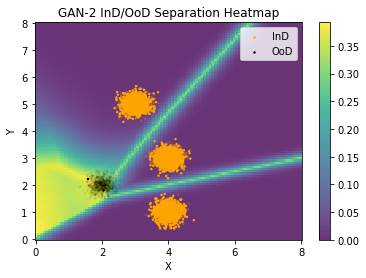

In [398]:
from simulation import plot_heatmap
plot = plot_heatmap(IND_X=IND_X, IND_X_TEST=IND_X_TEST, OOD_X=OOD_X, OOD_BATCH=OOD_BATCH, 
                    D=D_GAN, method=f"GAN-{n_ood}", m=100)

torch.Size([10000, 3])


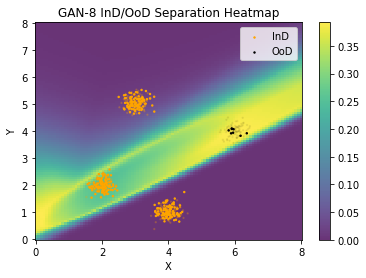

In [350]:
from simulation import plot_heatmap
plot = plot_heatmap(IND_X=IND_X, IND_X_TEST=IND_X_TEST, OOD_X=OOD_X, OOD_BATCH=OOD_BATCH, 
                    D=D_GAN, method=f"GAN-{n_ood}", m=100)

torch.Size([10000, 3])


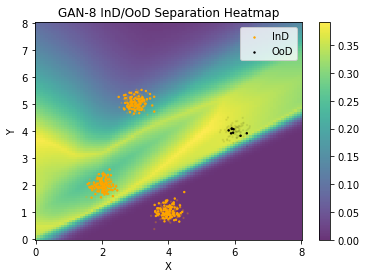

In [348]:
from simulation import plot_heatmap
plot = plot_heatmap(IND_X=IND_X, IND_X_TEST=IND_X_TEST, OOD_X=OOD_X, OOD_BATCH=OOD_BATCH, 
                    D=D_GAN, method=f"GAN-{n_ood}", m=100)

torch.Size([10000, 3])


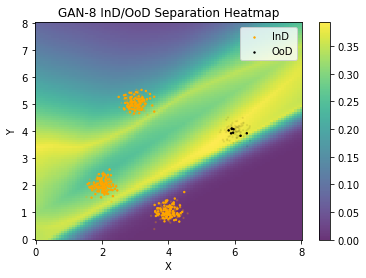

In [346]:
from simulation import plot_heatmap
plot = plot_heatmap(IND_X=IND_X, IND_X_TEST=IND_X_TEST, OOD_X=OOD_X, OOD_BATCH=OOD_BATCH, 
                    D=D_GAN, method=f"GAN-{n_ood}", m=100)

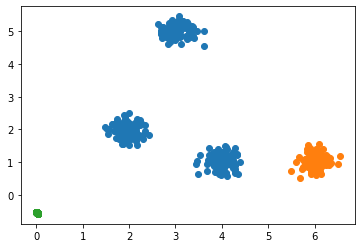

In [365]:
seed = torch.rand((128, 2))
gz = G_GAN(seed).detach().numpy()
plt.scatter(IND_X[:,0], IND_X[:,1])
plt.scatter(OOD_X[:,0], OOD_X[:,1])
plt.scatter(gz[:,0], gz[:,1])
plt.show()

In [399]:
from simulation import calculate_accuracy
calculate_accuracy(D=D_GAN, ind=IND_X, ood=OOD_X, tnr=0.95)

torch.Size([3000, 3])
torch.Size([3000])
0.006301604583859443
torch.Size([1000, 3])
tensor(1.)


In [400]:
calculate_accuracy(D=D_GAN, ind=IND_X, ood=OOD_X, tnr=0.99)

torch.Size([3000, 3])
torch.Size([3000])
0.011407736316323067
torch.Size([1000, 3])
tensor(1.)


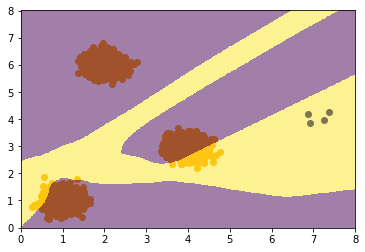

In [90]:
plt.scatter(IND_X[:,0], IND_X[:,1], c='orange', label ="InD", alpha=1)
# plt.scatter(OOD_X[:,0], OOD_X[:,1], c='navy', label="OoD", alpha=0.05)
plt.scatter(OOD_BATCH[:,0], OOD_BATCH[:,1], c='navy', label="OoD", alpha=1)
plt.pcolormesh(xi, yi, mask.reshape((m, m)).T, shading='auto', alpha=0.5)

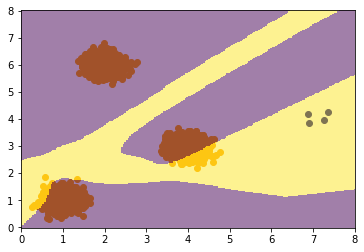

In [88]:
plt.scatter(IND_X[:,0], IND_X[:,1], c='orange', label ="InD", alpha=1)
# plt.scatter(OOD_X[:,0], OOD_X[:,1], c='navy', label="OoD", alpha=0.05)
plt.scatter(OOD_BATCH[:,0], OOD_BATCH[:,1], c='navy', label="OoD", alpha=1)
plt.pcolormesh(xi, yi, mask.reshape((m, m)).T, shading='auto', alpha=0.5)